# Parametric misalignment simulations

In this notebook we give an example of the analysis used to explore parametric misalignment in Section 3b.
We provide an example for one experiment and illustrate where changes could be made to explore other functions.

## Package imports

In [1]:
# library for packages not in the dk92 installation
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

# load pacakges
suppressPackageStartupMessages({
  library(tidyverse)
  library(rstan)
  library(bayesplot, lib.loc = additional_package_lib)
  library(patchwork)
  library(scico)
  library(posterior, lib.loc = additional_package_lib)
})

# rstan set up
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

# optional: set random seed
set.seed(230110)

## Utility functions

In [2]:
make_cond_prob_plot_x <- function(standata, stanfit){
  # Makes a plot with the conditional probabilities for the x variable 
  #
  # Inputs:
  #   standata  list
  #             the list that is passed to stan when fitting the model
  #   stanfit   stanfit object
  #             result of fitting a stan model from rstan
  #
  # Output:
  #   _         ggplot object
  #             the plot of x agains the probability of hail
    
    
  # range of data along which to plot
  x <- seq(min(standata$x), max(standata$x), length.out = 100)
  
  # getting samples from MCMC
  samples_alpha1 <- extract(stanfit, pars = "alpha1")$alpha1
  samples_alpha2 <- extract(stanfit, pars = "alpha2")$alpha2

  # preallocate matrix
  mat_func <- matrix(0, nrow = length(x), ncol = length(samples_alpha1))
  # calculating probability using each pair
  for (i in 1:length(samples_alpha1)) {
    mat_func[, i] <- 1 / (1 + exp(-(samples_alpha1[i] + samples_alpha2[i] * x)))
  }
  # summarise via quantile function
  res <- apply(mat_func, MARGIN = 1, FUN = quantile, probs = seq(0, 1, 0.025))
  res_mean <- rowMeans(mat_func)
  
  # plotting 
  fill_colour <- scico::scico(1, begin = 0.2, end = 0.8, palette = "batlow")
  ggplot(aes(x = x), data = NULL) +
    geom_ribbon(aes(ymin = res["2.5%", ], ymax = res["97.5%", ]), # 95% confidence interval
                data = NULL, alpha = 0.3, fill = fill_colour) +
    geom_ribbon(aes(ymin = res["25%", ], ymax = res["75%", ]),    # 50% confidence interval
                data = NULL, alpha = 0.5, fill = fill_colour) +
    geom_line(aes(y = res_mean), data = NULL) +                   # posterior mean
    labs(fill = "Confidence")
}

make_cond_prob_plot_y <- function(standata, stanfit){
  # Makes a plot with the conditional probabilities for the y variable 
  #
  # Inputs:
  #   standata  list
  #             the list that is passed to stan when fitting the model
  #   stanfit   stanfit object
  #             result of fitting a stan model from rstan
  #
  # Output:
  #   _         ggplot object
  #             the plot of x agains the probability of hail
    
    
  # range of data along which to plot
  y <- seq(min(standata$y), max(standata$y), length.out = 100)
  
  # getting samples from MCMC
  samples_beta1 <- extract(stanfit, pars = "beta1")$beta1
  samples_beta2 <- extract(stanfit, pars = "beta2")$beta2

  # preallocate matrix
  mat_func <- matrix(0, nrow = length(y), ncol = length(samples_beta1))
  # calculating probability using each pair
  for (i in 1:length(samples_beta1)) {
    mat_func[, i] <- 1 / (1 + exp(-(samples_beta1[i] + samples_beta2[i] * y)))
  }
  # summarise via quantile function
  res <- apply(mat_func, MARGIN = 1, FUN = quantile, probs = seq(0, 1, 0.025))
  res_mean <- rowMeans(mat_func)
  
  # plotting 
  fill_colour <- scico::scico(1, begin = 0.2, end = 0.8, palette = "batlow")
  ggplot(aes(x = y), data = NULL) +
    geom_ribbon(aes(ymin = res["2.5%", ], ymax = res["97.5%", ]), # 95% confidence interval
                data = NULL, alpha = 0.3, fill = fill_colour) +
    geom_ribbon(aes(ymin = res["25%", ], ymax = res["75%", ]),    # 50% confidence interval
                data = NULL, alpha = 0.5, fill = fill_colour) +
    geom_line(aes(y = res_mean), data = NULL) +                   # posterior mean
    labs(fill = "Confidence")
}

calculate_pvalues_by_grouping_col <- function(data, group, report, 
                                              ppc = "sim_report") {
  # Calculate p-values (lower and upper) by grouping by a given column.
  # 
  # Inputs:
  #   data    tibble
  #           assumed to have columns `group` with the grouping variable, `ppc#` 
  #           with the ppc draws, and `report` with the observations. Names user
  #           supplied.
  #   group   colunm of data
  #           contains the grouping value 
  #   ppc     str
  #           name of the columns with the posterior predictive 
  #           samples from which metrics are calculated. 
  #           default is "sim_report"
  #   report  column of data
  #           contains the ground truth
  #   
  # Output:
  #   _       tibble
  #           colunms corresponding to the group and lower and upper tailed 
  #           p-values
  
  # turn given column name into a format r likes
  group_name <- enquo(group)
  report_col <- enquo(report)
  
  data %>%
    # group by the groups
    group_by(!!group_name) %>%
    # take sums within groups
    summarise(across(c(!!report_col, starts_with(ppc)), sum)) %>%
    # make rowwise tibble
    rowwise() %>%
    # calculate the pvalues
    mutate(pvalue_upper = mean(c_across(starts_with(ppc)) >= !!report_col),
           pvalue_lower = mean(c_across(starts_with(ppc)) <= !!report_col)) %>%
    # gets rid of ppc for display 
    select(-starts_with(ppc), -!!report_col)
}


## Generating data

Below we generate both $x$ and $y$ from the uniform distribution on $[0, 1]$ but this could be changed. 
For example, to generate from the exponential distribution replace the indicated line with 

```
rexp(num_points + 100, rate = -log(1e-3))
```

Note that we have generated more than `num_points` here and would then filter for `x > 1` and use `head(num_points)` to select only the first `num_points` observations.

The line needed to change the hail function is also indicated. Note this change must also follow through in other locations indicated.

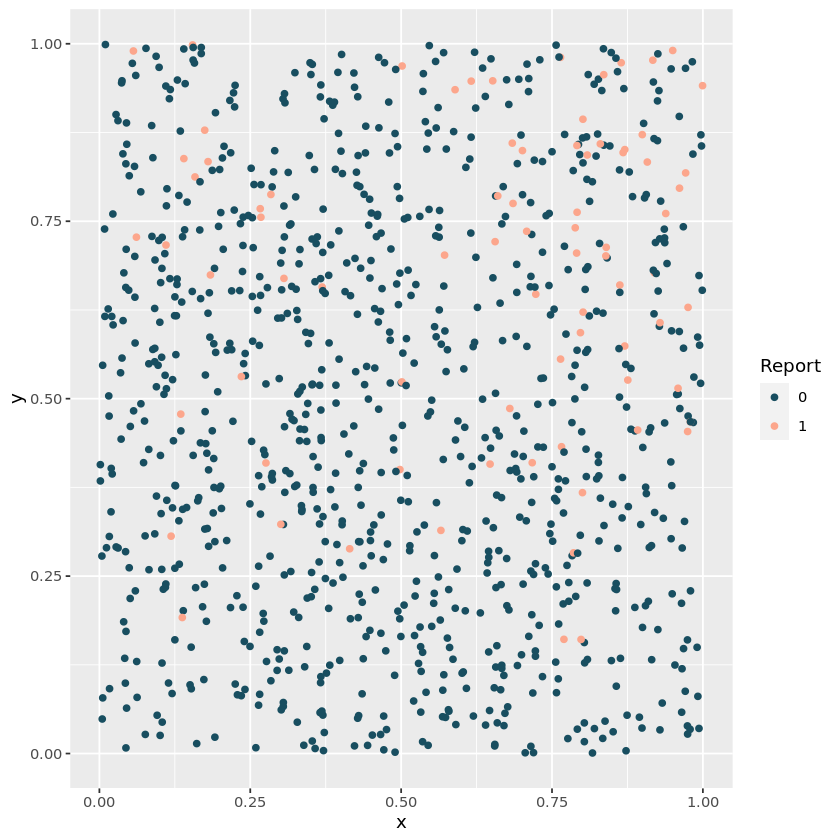

In [3]:
num_points <- 1000 # number of observations in experiments

# generating syntehtic predictors
preds <- tibble(x = runif(num_points), # x ~ U(0, 1) - can be changed.
                y = runif(num_points)) # y ~ U(0, 1) 

# linear parameters
# note: chosen so that the functions alpha1 * x^2 + alpha2 and 
#       beta1 * y + beta2 don't pass through (1, 1)
alpha1 <- 0.5 
alpha2 <- 0.17
beta1 <- 0.5
beta2 <- 0

# simulating reports
preds <- preds %>%
  # P(R = 1) = P(H = 1) x P(R = 1 | H = 1)
  mutate(linear_prob = (alpha1 * (x^2) + alpha2) * (beta1 * y + beta2)) %>% # change here for linear, exponential functions
  # random numbers from which to simulate report
  add_column(linear_random = runif(num_points)) %>%
  # getting report as an integer
  mutate(linear_report = 1 * (linear_random < linear_prob))

# plotting bivariate distribution coloured by report
preds %>%
  mutate(linear_report = as_factor(linear_report)) %>%
  ggplot(aes(x = x, y = y, color = linear_report)) +
  geom_point() +
  scale_color_manual("Report", values = scico::scico(2, begin = 0.2, end = 0.8, palette = "batlow"))

## Fitting with stan

Note that we use below a simplified, non-matrix, description of the model for concision as this script does not need to be as generalisable.
The models, however, are equivalent mathematically. 

In [4]:
stan_model <- "
// data block - given x, y, reports and number of data points
data {
  int<lower=0> n;
  vector<lower=0, upper=1>[n] x;
  vector<lower=0, upper=1>[n] y;
  int<lower=0, upper=1> report[n];
}

// parameters - no alpha3 and beta3
// note: these parameters should not correspond exactly in value to the 
//       just defined alpha1 etc.
parameters {
  real alpha1;
  real<lower=0> alpha2;
  real beta1;
  real<lower=0> beta2;
} 

// using transformed parameters to calculate reporting probabilities using
// the inverse logit function
transformed parameters {
  real<lower=0, upper=1> prob_x[n];
  real<lower=0, upper=1> cond_prob_y[n];
  real<lower=0, upper=1> prob_report[n];
  for (i in 1:n){
    prob_x[i] = inv_logit(alpha1 + alpha2 * x[i]);
    cond_prob_y[i] = inv_logit(beta1 + beta2 * y[i]);
    prob_report[i] = prob_x[i] * cond_prob_y[i];
  }
}

// simple priors on all parameters
model {
  report ~ bernoulli(prob_report);
  alpha1 ~ normal(0, 1);
  alpha2 ~ normal(0, 1);
  beta1 ~ normal(0, 1);
  beta2 ~ normal(0, 1);
} 

// generating simulated reports so that Bayesian p-values can be calculated
// if desired
generated quantities {
  int<lower=0, upper=1> sim_report[n];
  sim_report = bernoulli_rng(prob_report);
}
  
"

# stan data as a list 
stan_data_linear <- list(n = num_points,
                         x = preds %>% select(x) %>% pull,
                         y = preds %>% select(y) %>% pull,
                         report = preds %>% select(linear_report) %>% pull)

# fit model using stan
fit_linear <- stan(model_code = stan_model, data = stan_data_linear, 
                   pars = c("alpha1", "alpha2", "beta1", "beta2", "sim_report"))

## Assessing MCMC diagnostics

In [5]:
# summary of key parameters
fit_linear %>% 
  as_draws_df %>% # convert fit to a draws_df object for posterior package
  summary %>% # summarise the draws
  filter(!str_detect(variable, "sim_report")) # remove the sim reports to just see key parameters 
                                              # and their numerical diagnostics

variable mean        median      sd        mad       q5          
1 alpha1     -1.792455   -1.827241 0.4937902 0.4842917   -2.5282245
2 alpha2      1.730932    1.710025 0.4821228 0.4786774    0.9700235
3 beta1      -2.157000   -2.171222 0.4718262 0.4647682   -2.9115226
4 beta2       2.356596    2.330581 0.5501773 0.5655107    1.5144875
5 lp__     -258.615709 -258.255228 1.5195045 1.2830700 -261.4180081
  q95          rhat      ess_bulk ess_tail
1   -0.9163036 0.9996844 1970.347 2168.175
2    2.5541149 1.0007946 2606.158 1617.181
3   -1.3460616 1.0015218 1870.103 1841.918
4    3.2867522 1.0016058 2002.245 1649.759
5 -256.8544744 1.0027800 1425.071 1533.814

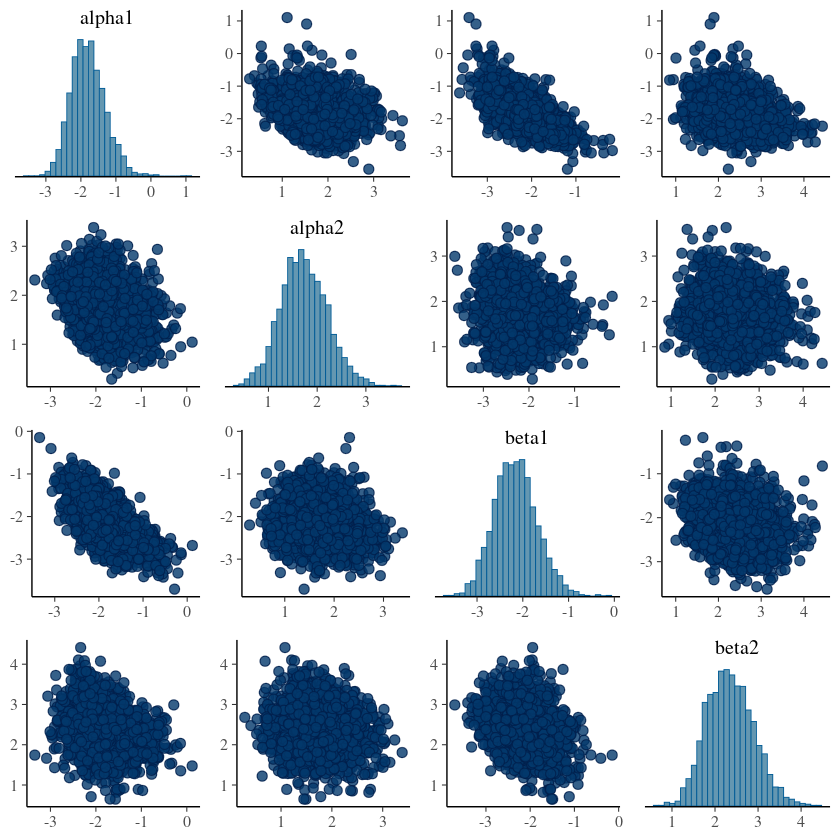

In [6]:
# pairs plot to view the bivariate posterior distributions
# see https://mc-stan.org/bayesplot/reference/MCMC-scatterplots.html 
# for further details on interpretting this plot

# get the parameters from the NUTS algorithm, will highlight divergent transitions
np <- nuts_params(fit_linear)

# create the pairs plot
mcmc_pairs(fit_linear, pars = c("alpha1", "alpha2", "beta1", "beta2"), np = np)

## Assessing model fit

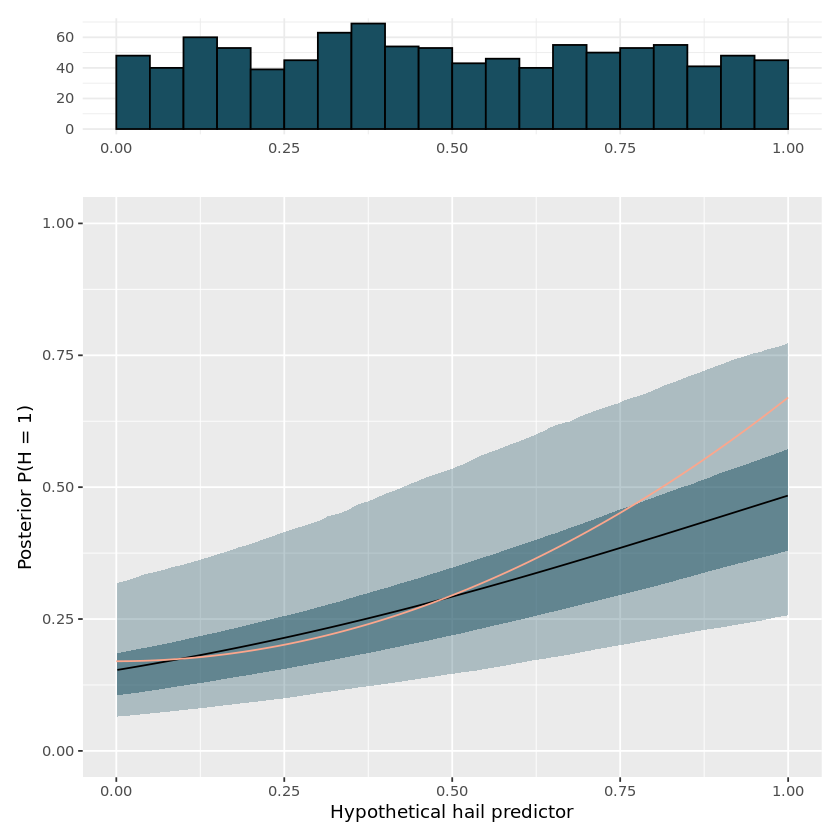

In [7]:
# making the basic conditional plot for P(H = 1) given x
p <- make_cond_prob_plot_x(stan_data_linear, fit_linear)

# adding the true line
p <- p +
  geom_line(aes(x = x, y = y), 
            data = tibble(x = seq(0, 1, by = 0.01)) %>% 
              mutate(y = alpha1 * (x^2) + alpha2), # need to change this line if not using the quadratic function
            color = scico::scico(2, begin = 0.2, end = 0.8, palette = "batlow")[2]) +
  xlim(0, 1) +
  ylim(0, 1) +
  # formatting axis labels
  xlab("Hypothetical hail predictor") +
  ylab("Posterior P(H = 1)")

# making a marginal histogram of x to also display
p_x_marg <- preds %>%
  ggplot(aes(x = x)) + 
  geom_histogram(breaks = seq(0, 1, by = 0.05), color = "black", 
                 fill = scico::scico(1, begin = 0.2, end = 0.8, palette = "batlow")) +
  xlab("") + 
  ylab("") +
  theme_minimal()

p_x_marg / p + plot_layout(height = c(1, 5))

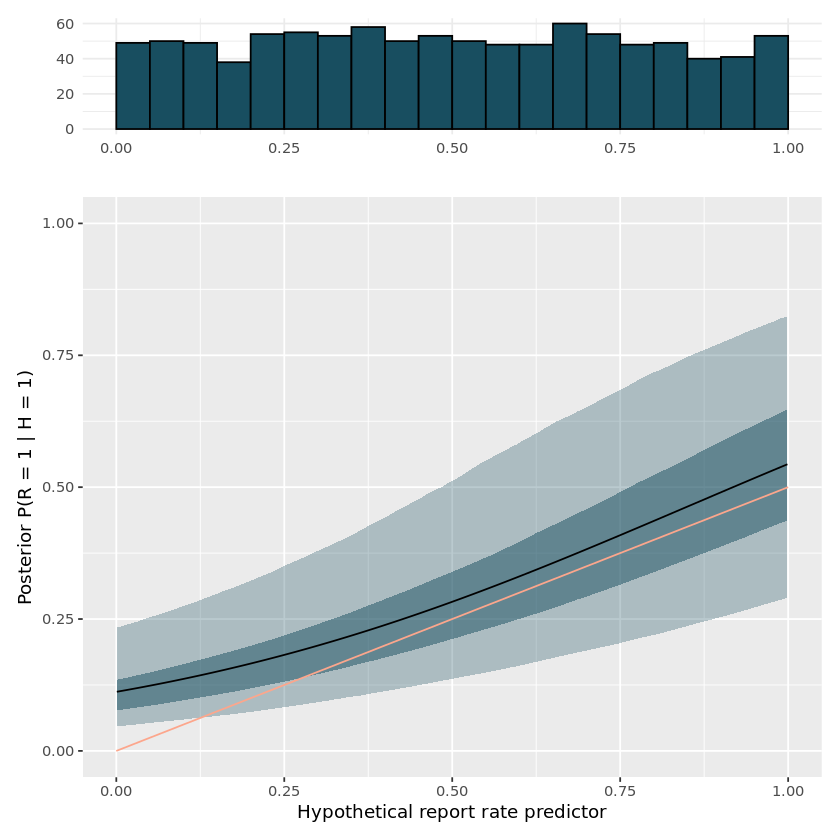

In [8]:
# making the basic conditional plot
p <- make_cond_prob_plot_y(stan_data_linear, fit_linear)

# adding the true line
p <- p +
  geom_line(aes(x = x, y = y), 
            data = tibble(x = seq(0, 1, by = 0.01)) %>% 
              mutate(y = beta1 * x + beta2), 
            color = scico::scico(2, begin = 0.2, end = 0.8, palette = "batlow")[2]) +
  xlim(0, 1) +
  ylim(0, 1) +
  # formatting axis labels
  xlab("Hypothetical report rate predictor") +
  ylab("Posterior P(R = 1 | H = 1)")

# making a marginal predictor to add
p_y_marg <- preds %>%
  ggplot(aes(x = y)) + 
  geom_histogram(breaks = seq(0, 1, by = 0.05), color = "black", 
                 fill = scico::scico(1, begin = 0.2, end = 0.8, palette = "batlow")) +
  xlab("") + 
  ylab("") +
  theme_minimal()

p_y_marg / p + plot_layout(height = c(1, 5))

In [9]:
# noisy function which calculates Bayesian p-values
suppressWarnings({
  suppressMessages({
    extract(fit_linear, pars = "sim_report") %>%
      pluck("sim_report") %>% # selects the posterior predictive samples 
      # converting to a more amenable format
      as_draws_df %>%
      select(starts_with("...")) %>%
      t() %>%
      bind_cols(preds, .name_repair = "unique") %>% 
      rename_with(~ paste0("sim_report", str_replace(.x, "...", "")), starts_with("...")) %>%
      # dividing into five equal bins
      mutate(x_bins = cut(x, breaks = seq(0, 1, by = 0.2))) %>%
      # calculating p-values appropriately
      calculate_pvalues_by_grouping_col(x_bins, linear_report)
    })
})

x_bins    pvalue_upper pvalue_lower
1 (0,0.2]   0.31175      0.77400     
2 (0.2,0.4] 0.93625      0.11000     
3 (0.4,0.6] 0.98925      0.02125     
4 (0.6,0.8] 0.19175      0.86000     
5 (0.8,1]   0.19400      0.84750